In [1]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import json
import ast
import numpy as np
from embedding import load_graph_network
from train import fit_transform
from embedData import embedData
import torch
from scipy.sparse import identity, csr_matrix
import re

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## loss curves

In [2]:
# 读取日志文件
with open('./output.log', 'r') as f:
    lines = f.readlines()

In [3]:
# 正则表达式匹配Epoch、Train Loss、Validation Loss
pattern = r'Epoch: (\d+), Train Loss: ([\d.]+), Validation Loss: ([\d.]+)'
epochs = []
train_loss = []
val_loss = []

for line in lines:
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_loss.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))

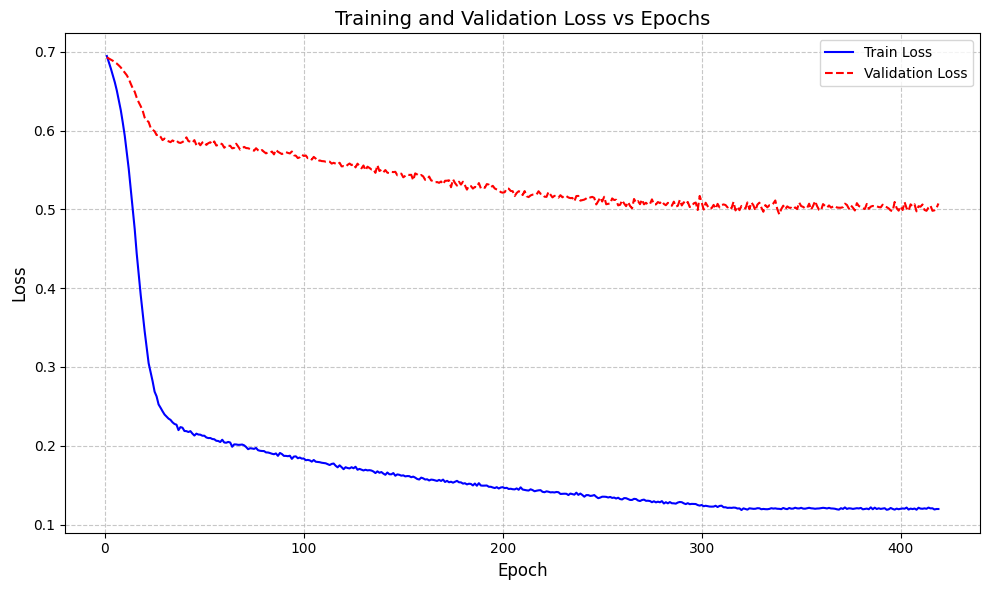

In [4]:
# 绘制曲线
plt.figure(figsize=(10, 6))

# 训练损失曲线（蓝色实线）
plt.plot(epochs, train_loss, '-b', label='Train Loss')

# 验证损失曲线（红色虚线）
plt.plot(epochs, val_loss, '--r', label='Validation Loss')

# 添加标题和坐标轴标签
plt.title('Training and Validation Loss vs Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 添加图例和网格
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 自动调整子图边距
plt.tight_layout()

# 保存图片（可选）
plt.savefig('loss_curves.png', dpi=300)

# 显示图像
plt.show()

## random walk with restart

In [22]:
import torch
import numpy as np
import torch_geometric
from torch_scatter import scatter_add
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [28]:
class RWRPyG:
    """使用PyTorch Geometric实现的Random Walk with Restart"""
    
    def __init__(self, feature_matrix, node_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        初始化RWRPyG类
        
        参数:
            feature_matrix: numpy数组，形状为(n_samples, n_features)
            node_names: 节点名称列表，长度为n_samples
            device: 计算设备，'cpu'或'cuda'
        """
        self.feature_matrix = feature_matrix
        self.node_names = node_names  # 新增节点名称列表
        self.name_to_idx = {name: i for i, name in enumerate(node_names)}  # 名称到索引的映射
        self.device = device
        self.n_samples = feature_matrix.shape[0]
        self.edge_index = None
        self.edge_weight = None
        self.rwr_model = None
        
    def build_graph(self, k_neighbors=10, metric='cosine', threshold=None, symmetrize=True):
        """
        基于K近邻构建相似性图
        
        参数:
            k_neighbors: K近邻参数
            metric: 距离度量，支持'cosine'、'euclidean'等
            threshold: 相似性阈值，低于此值的边将被忽略
            symmetrize: 是否确保图的对称性
        """
        print(f"构建相似性图 (k={k_neighbors}, metric={metric})...")
        
        # 计算K近邻图
        adj_matrix = kneighbors_graph(
            X=self.feature_matrix, n_neighbors=k_neighbors, mode='distance', 
            metric=metric, include_self=False
        )
        
        # 转换为相似度
        if metric == 'cosine':
            # 余弦相似度 = 1 - 余弦距离
            adj_matrix.data = 1.0 - adj_matrix.data
        else:
            # 对于欧氏距离等，使用高斯核
            adj_matrix.data = np.exp(-adj_matrix.data)
        
        # 应用阈值
        if threshold is not None:
            adj_matrix.data[adj_matrix.data < threshold] = 0
            adj_matrix.eliminate_zeros()
        
        # 确保图的对称性
        if symmetrize:
            adj_matrix = 0.5 * (adj_matrix + adj_matrix.T)
        
        # 转换为PyG格式
        self.edge_index, self.edge_weight = torch_geometric.utils.from_scipy_sparse_matrix(adj_matrix)
        self.edge_index = self.edge_index.to(self.device)
        self.edge_weight = self.edge_weight.to(self.device).float()
        
        print(f"图构建完成: {self.n_samples} 个节点, {self.edge_index.shape[1]} 条边")
        return self
    
    def compute_rwr(self, seeds, alpha=0.85, max_iter=100, tol=1e-6):
        """
        计算RWR得分
        
        参数:
            seeds: 种子节点的索引列表
            alpha: 重启概率
            max_iter: 最大迭代次数
            tol: 收敛容差
            
        返回:
            numpy数组，每个节点的RWR得分
        """
        if self.edge_index is None:
            raise ValueError("请先调用build_graph方法构建图")
            
        print(f"计算RWR (alpha={alpha}, seeds={len(seeds)})...")
        
        # 初始化RWR向量
        r = torch.zeros(self.n_samples, dtype=torch.float, device=self.device)
        r[seeds] = 1.0 / len(seeds)
        r_old = r.clone()
        
        # 构建转移矩阵（归一化邻接矩阵）
        row, col = self.edge_index
        deg = torch_geometric.utils.degree(row, self.n_samples, dtype=self.edge_weight.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        edge_weight_norm = deg_inv_sqrt[row] * self.edge_weight * deg_inv_sqrt[col]
        
        # 迭代计算RWR
        for i in range(max_iter):
            # 传播步骤
            r_new = scatter_add(
                src=edge_weight_norm * r_old[col],
                index=row, dim=0, dim_size=self.n_samples
            )
            
            # 重启步骤
            r_new = (1 - alpha) * r_new  # 缩放传播结果
            r_new[seeds] += alpha / len(seeds)  
            
            # 检查收敛
            diff = torch.norm(r_new - r_old, p=1)
            if diff < tol:
                print(f"RWR在第 {i+1} 次迭代后收敛 (diff={diff:.6e})")
                break
                
            r_old = r_new.clone()
            
        return r_new.cpu().numpy()

In [29]:
feature_matrix = np.load('../Data/UKB_feature.npy')

In [46]:
feature_matrix.shape

(59341, 512)

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=42)
feature_matrix_pca = pca.fit_transform(feature_matrix)
print(f"PCA降维后形状: {feature_matrix_pca.shape}")
print(f"解释方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")

PCA降维后形状: (59341, 3)
解释方差比例: 1.000


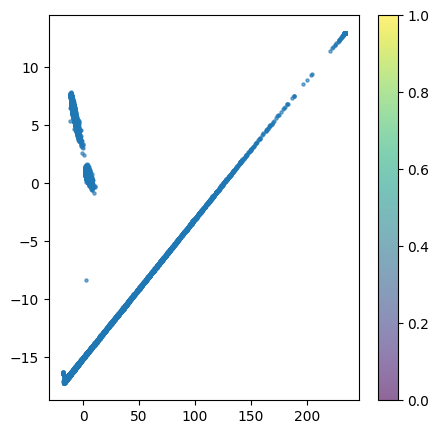

In [51]:
# 5. 可视化结果 (使用PCA的前两个主成分)
plt.figure(figsize=(5, 5))
scatter = plt.scatter(feature_matrix_pca[:, 0], feature_matrix_pca[:, 1], 
                      alpha=0.6, s=5)
plt.colorbar(scatter)

In [30]:
# 读取graph node names
with open('../Data/keys.json', 'r') as f:
    loaded_keys = json.load(f)

In [31]:
len(loaded_keys)

59341

In [32]:
# 初始化RWRPyG
print("初始化RWRPyG...")
rwr = RWRPyG(feature_matrix=feature_matrix, node_names=loaded_keys, device='cuda')

# 构建图
rwr.build_graph(k_neighbors=15, metric='cosine')

初始化RWRPyG...
构建相似性图 (k=15, metric=cosine)...
图构建完成: 59341 个节点, 1476048 条边


In [8]:
feature_matrix[:5,:5]

array([[ 1.1152157 ,  1.1192651 , -0.07948627,  1.4840436 ,  0.7951089 ],
       [ 1.2655164 ,  1.1099303 , -0.16148649,  0.81501377,  0.99891466],
       [ 1.087629  ,  1.1460577 , -0.07352173,  1.4985468 ,  0.7628279 ],
       [ 1.1143917 ,  1.1762134 , -0.06481926,  1.6371577 ,  0.7758594 ],
       [ 1.303605  ,  1.0933878 , -0.1734011 ,  0.70877016,  1.0936706 ]],
      dtype=float32)

In [33]:
try:
    select_index = rwr.name_to_idx["C920"]
    print(f"找到节点，索引为 {select_index}")
except KeyError:
    print(f"错误：未找到节点")
    exit()

找到节点，索引为 3206


In [34]:
# 执行RWR计算，以select_index为种子节点
rwr_scores = rwr.compute_rwr(seeds=[select_index], alpha=0.5)

# 获取得分最高的前50个节点的索引（排除种子节点自身）
top_indices = np.argsort(rwr_scores)[::-1]
top_indices = top_indices[top_indices != select_index][:50]  # 排除种子节点

# 获取对应的节点名称和得分
top_node_names = [rwr.node_names[idx] for idx in top_indices]
top_node_scores = rwr_scores[top_indices]

# 打印结果
print("\n基于select节点的RWR最可及的前50个节点：")
print("排名\t节点名称\tRWR得分")
for rank, (name, score) in enumerate(zip(top_node_names, top_node_scores), 1):
    print(f"{rank}\t{name}\t{score:.6f}")

计算RWR (alpha=0.5, seeds=1)...
RWR在第 12 次迭代后收敛 (diff=3.824745e-07)

基于select节点的RWR最可及的前50个节点：
排名	节点名称	RWR得分
1	H578	0.014172
2	4701401	0.012667
3	2230426	0.011412
4	G721	0.008664
5	I831	0.008285
6	4978002	0.007205
7	R768	0.006978
8	1489795	0.006202
9	C159	0.005646
10	1360861	0.005345
11	3897810	0.004885
12	2949550	0.004815
13	3497747	0.004755
14	3018925	0.004585
15	3435702	0.004285
16	3551057	0.004095
17	3243421	0.003830
18	5216026	0.003751
19	K419	0.000621
20	5786953	0.000504
21	2505137	0.000477
22	2954973	0.000435
23	3525992	0.000397
24	5649933	0.000386
25	2943696	0.000376
26	4098733	0.000371
27	3238131	0.000367
28	1578982	0.000365
29	1236974	0.000365
30	2134934	0.000356
31	4757866	0.000342
32	2291731	0.000339
33	M101	0.000336
34	3632189	0.000336
35	1275870	0.000330
36	2496913	0.000323
37	2617370	0.000307
38	3549038	0.000303
39	3293499	0.000303
40	3093704	0.000292
41	6013030	0.000292
42	C903	0.000291
43	5955378	0.000286
44	4763287	0.000282
45	5580592	0.000280
46	5894383	0.000275
47	218